In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.gen(x)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  
batch_size = 32
num_epochs = 50


In [5]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]
)

In [6]:
dataset = datasets.FashionMNIST(root="~/.pytorch/F_MNIST_data", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw




Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw




Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw




Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

Epoch [0/50] Batch 0/1875                       Loss D: 0.7175, loss G: 0.6918
Epoch [1/50] Batch 0/1875                       Loss D: 0.2961, loss G: 1.8383
Epoch [2/50] Batch 0/1875                       Loss D: 0.3410, loss G: 1.5797
Epoch [3/50] Batch 0/1875                       Loss D: 0.4354, loss G: 1.7165
Epoch [4/50] Batch 0/1875                       Loss D: 0.2351, loss G: 2.4648
Epoch [5/50] Batch 0/1875                       Loss D: 0.4289, loss G: 1.7048
Epoch [6/50] Batch 0/1875                       Loss D: 0.5882, loss G: 1.3558
Epoch [7/50] Batch 0/1875                       Loss D: 0.5906, loss G: 1.4416
Epoch [8/50] Batch 0/1875                       Loss D: 0.5713, loss G: 1.4428
Epoch [9/50] Batch 0/1875                       Loss D: 0.7149, loss G: 1.7321
Epoch [10/50] Batch 0/1875                       Loss D: 0.8424, loss G: 1.2762
Epoch [11/50] Batch 0/1875                       Loss D: 0.4188, loss G: 1.4246
Epoch [12/50] Batch 0/1875                       L

In [11]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

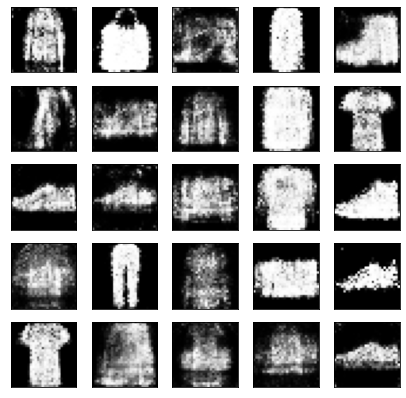

In [12]:
rand_z = torch.randn(25, z_dim).to(device)
gen.eval()
rand_images = gen(rand_z)
view_samples(0, [rand_images.cpu()])